In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
from itertools import combinations

In [2]:
n_features = 2
# Generate synthetic data with the specified parameters
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate hinge loss on the test data
test_loss = hinge_loss(y_test, y_pred)

print(f"Test Loss: {test_loss:.4f}")

# Get the indices of support vectors
support_vector_indices = svm_classifier.support_

print("Indices of Support Vectors:")
print(support_vector_indices)

Accuracy: 78.00%
Test Loss: 0.7000
Indices of Support Vectors:
[ 2  5 12 14 17 18 21 25 29 32 36 42 44 48 49  1  3  6  7 11 13 15 23 27
 28 31 33 40 41 43]


In [3]:
# Initialize variables to store the nearest test point index and distance
nearest_point_index = None
nearest_distance = float("inf")

# Iterate through all test points to find the nearest point to the decision boundary
for i, test_point in enumerate(X_test):
    # Calculate the signed distance to the decision boundary for the current test point
    distance_to_boundary = svm_classifier.decision_function([test_point])
    
    # Get the absolute distance
    abs_distance = np.abs(distance_to_boundary)
    
    # Update the nearest point if the current test point is closer to the decision boundary
    if abs_distance < nearest_distance:
        nearest_distance = abs_distance
        nearest_point_index = i

# Get the index of the nearest test point
nearest_test_point_index = nearest_point_index

print(f"Index of Nearest Test Point to Decision Boundary: {nearest_test_point_index}")

Index of Nearest Test Point to Decision Boundary: 39


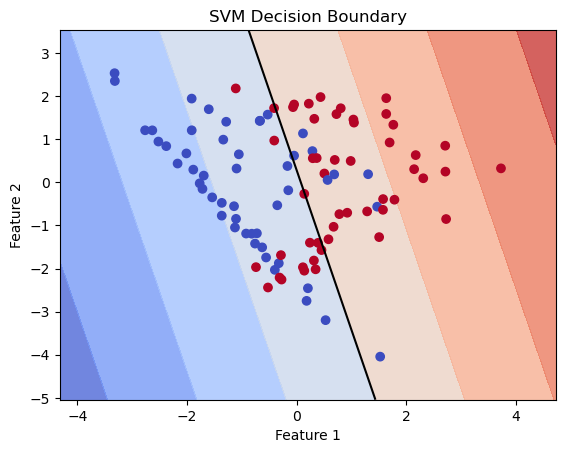

In [4]:
if n_features == 2:
	# Plot the decision boundary
	xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
						np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
	Z = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
	Z = Z.reshape(xx.shape)

	plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
	plt.contour(xx, yy, Z, colors='black', linestyles='-', levels=[0])
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('SVM Decision Boundary')
	plt.show()
else: 
	from sklearn.decomposition import PCA

	# Reduce dimensionality using PCA to 2 components
	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X)

	# Create a mesh grid for the reduced feature space
	x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
	y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
	Z = svm_classifier.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
	Z = Z.reshape(xx.shape)

	# Plot the decision boundary in the reduced 2D space
	plt.contour(xx, yy, Z, colors='black', linestyles='--', levels=[0])
	plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
	plt.xlabel('Principal Component 1')
	plt.ylabel('Principal Component 2')
	plt.title('SVM Decision Boundary (Reduced to 2D)')
	plt.show()

In [5]:
def brute_force_removal(original_svm_classifier, X_train, y_train, X_test, y_test, fixed_test_point_index, max_size):
	# Initialize variables to keep track of the best subset and loss difference for fixed test point
	best_subset_fix_test = np.full((max_size), None)
	best_reduced_Z_fix_test = np.full((max_size), None)

	# Initialize variables to keep track of the best subset and loss difference for total loss
	best_subset_total_loss = np.full((max_size), None)
	best_reduced_Z_total_loss = np.full((max_size), None)

	# Initialize variables to keep track of the best subset and loss difference for parameter changes
	best_subset_parameter = np.full((max_size), None)
	best_reduced_Z_parameter = np.full((max_size), None)

	# Loop over different subset sizes from 1 to max_size
	for subset_size in range(1, max_size + 1):
		# Generate all combinations of subsets of the current size
		subset_combinations = combinations(range(X_train.shape[0]), subset_size)
		
		max_loss_difference_fix_test = -float("inf")
		max_loss_difference_total_loss = -float("inf")
		max_parameter_difference = -float("inf")


		for subset_to_remove in subset_combinations:
			# Create a new training set without the selected data points
			reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
			reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)
			
			# Train an SVM classifier on the reduced training set
			reduced_svm_classifier = SVC(kernel='linear', C=1.0)
			reduced_svm_classifier.fit(reduced_X_train, reduced_y_train)

			
			## Fixed test point
			fixed_test_point = X_test[fixed_test_point_index]
			true_label = y_test[fixed_test_point_index]

			# Make predictions on the fixed test point using the reduced model
			reduced_y_pred = reduced_svm_classifier.predict([fixed_test_point])
			
			reduced_loss = hinge_loss([true_label], [reduced_y_pred])
			original_loss = hinge_loss([true_label], [svm_classifier.predict([fixed_test_point])])

			# Calculate the loss difference
			loss_difference = abs(original_loss - reduced_loss)

			# Update if the current subset induces the maximum change in test loss
			if loss_difference > max_loss_difference_fix_test:
				max_loss_difference_fix_test = loss_difference
				best_subset_fix_test[subset_size-1] = subset_to_remove
				best_reduced_Z_fix_test[subset_size-1] = reduced_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


			## Total loss
			# Make predictions on the fixed test point using the reduced model
			reduced_y_pred = reduced_svm_classifier.predict(X_test)
			
			original_loss = hinge_loss(y_test, y_pred)
			reduced_loss = hinge_loss(y_test, reduced_y_pred)
			total_loss_difference = abs(original_loss - reduced_loss)

			# Update if the current subset induces the maximum change in test loss
			if total_loss_difference > max_loss_difference_total_loss:
				max_loss_difference_total_loss = total_loss_difference
				best_subset_total_loss[subset_size-1] = subset_to_remove
				best_reduced_Z_total_loss[subset_size-1] = reduced_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

			
			## Parameter changes
			# Get the parameters of the original model
			original_coef = original_svm_classifier.coef_
			original_intercept = original_svm_classifier.intercept_

			# Get the parameters of the reduced model
			reduced_coef = reduced_svm_classifier.coef_
			reduced_intercept = reduced_svm_classifier.intercept_
			
			# Calculate the L2 norm of the parameter difference
			parameter_difference = np.linalg.norm(reduced_coef - original_coef) + np.linalg.norm(reduced_intercept - original_intercept)

			# Update if the current subset induces the maximum change in parameters
			if parameter_difference > max_parameter_difference:
				max_parameter_difference = parameter_difference
				best_subset_parameter[subset_size-1] = subset_to_remove
				best_reduced_Z_parameter[subset_size-1] = reduced_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

	return [best_subset_fix_test, best_reduced_Z_fix_test], [best_subset_total_loss, best_reduced_Z_total_loss], [best_subset_parameter, best_reduced_Z_parameter]

In [6]:
# Choose a fixed test point
fixed_test_point_index = nearest_test_point_index  # Replace with the index of your chosen test point

max_size = 5

fix_test, total_loss, parameter = brute_force_removal(svm_classifier, X_train, y_train, X_test, y_test, fixed_test_point_index, max_size)

Best Subset of Removed Data Points for Fixed Test Point Loss with Size 1: (2,)


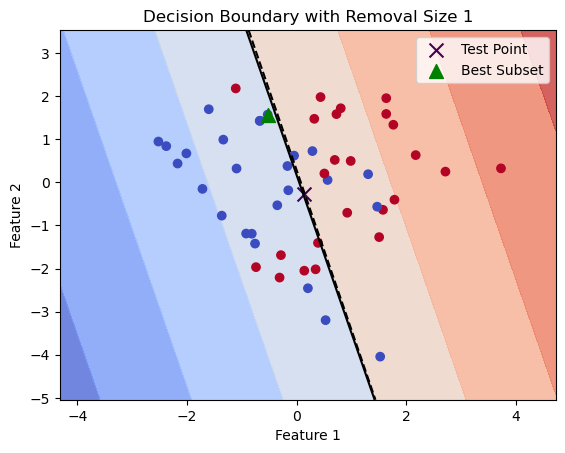

Best Subset of Removed Data Points for Fixed Test Point Loss with Size 2: (0, 2)


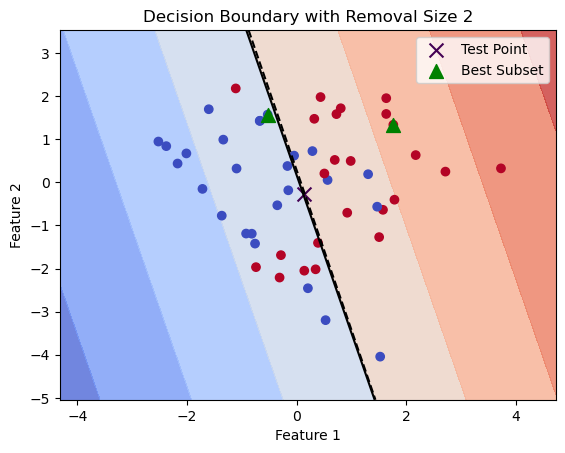

Best Subset of Removed Data Points for Fixed Test Point Loss with Size 3: (0, 1, 17)


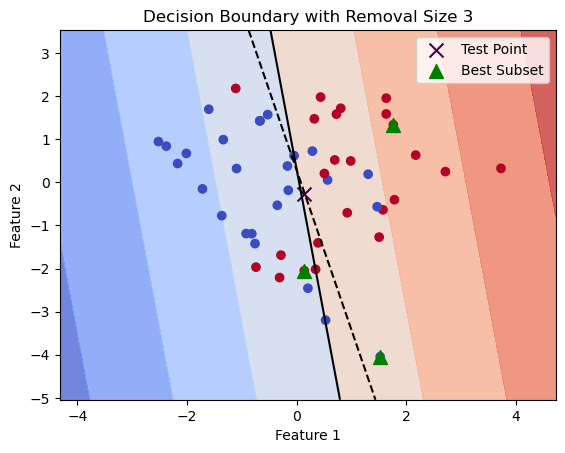

Best Subset of Removed Data Points for Fixed Test Point Loss with Size 4: (0, 1, 2, 17)


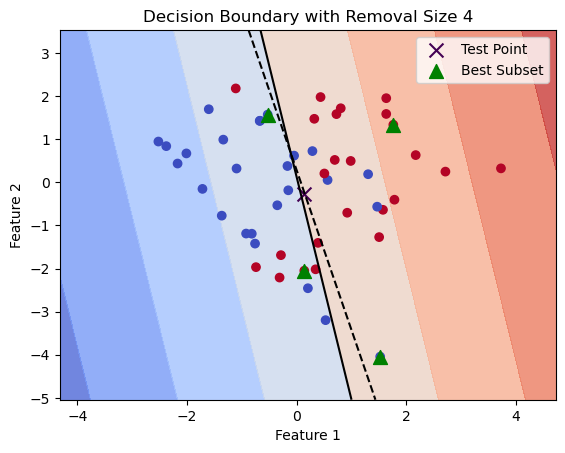

Best Subset of Removed Data Points for Fixed Test Point Loss with Size 5: (0, 1, 2, 4, 17)


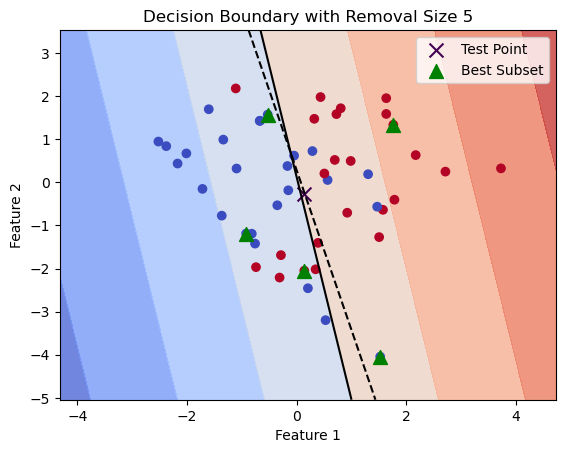

In [7]:
for subset_size in range(1, max_size + 1):
	print(f"Best Subset of Removed Data Points for Fixed Test Point Loss with Size {subset_size}: {fix_test[0][subset_size-1]}")
	
	# Plot the decision boundary of the original model and the reduced model, and mark the test point
	plt.figure()

	# Plot the decision boundary of the reduced model (solid line)
	plt.contourf(xx, yy, fix_test[1][subset_size-1], cmap=plt.cm.coolwarm, alpha=0.8)
	plt.contour(xx, yy, fix_test[1][subset_size-1], colors='black', linestyles='-', levels=[0])

	# Plot the decision boundary of the original model (dashed line)
	original_Z = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
	plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

	# Mark the dataset points with a marker ('o' symbol)
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')

	# Mark the test point with a marker ('x' symbol)
	fixed_test_point = X_test[fixed_test_point_index]
	plt.scatter(fixed_test_point[0], fixed_test_point[1], c=y_test[fixed_test_point_index], marker='x', s=100, label="Test Point")

	# Mark the best subset of removed data points with a different marker ('^' symbol)
	best_subset_points = np.take(X_train, fix_test[0][subset_size-1], axis=0).reshape(-1, 2)
	plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='g', marker='^', s=100, label="Best Subset")

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title(f'Decision Boundary with Removal Size {subset_size}')
	plt.legend()
	plt.show()

Best Subset of Removed Data Points for Total Loss with Size 1: (29,)


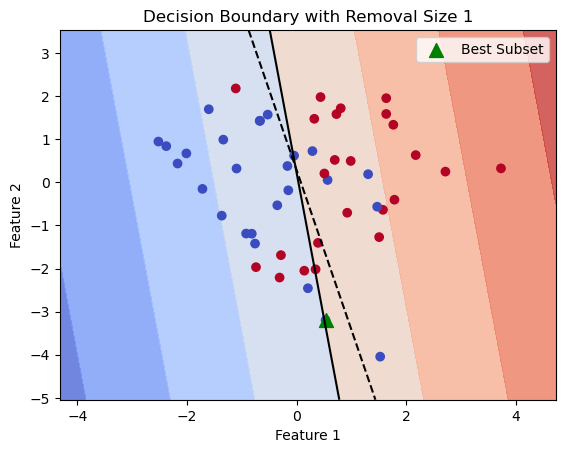

Best Subset of Removed Data Points for Total Loss with Size 2: (33, 41)


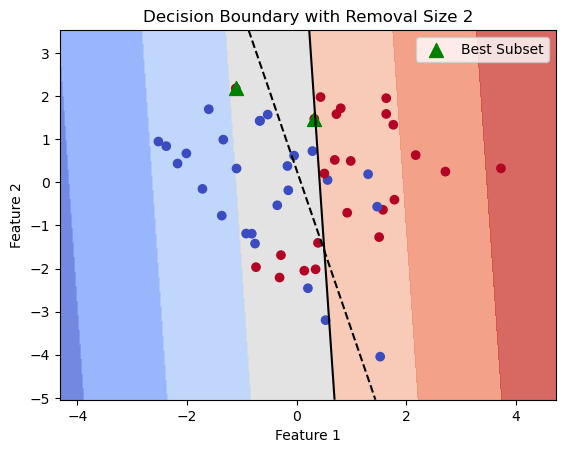

Best Subset of Removed Data Points for Total Loss with Size 3: (1, 23, 24)


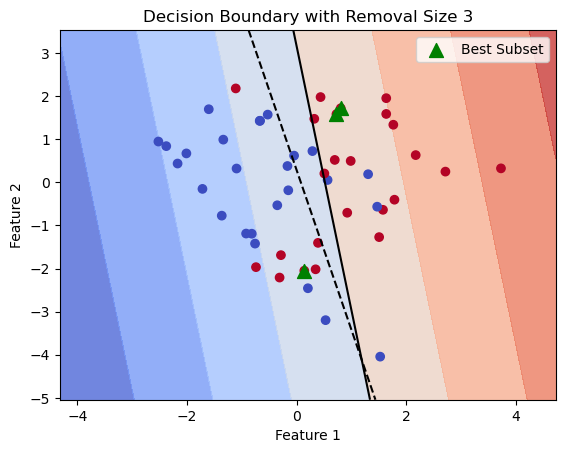

Best Subset of Removed Data Points for Total Loss with Size 4: (1, 11, 23, 24)


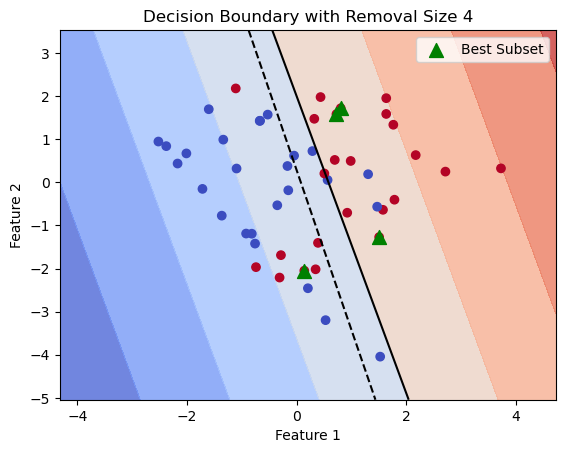

Best Subset of Removed Data Points for Total Loss with Size 5: (1, 3, 11, 23, 28)


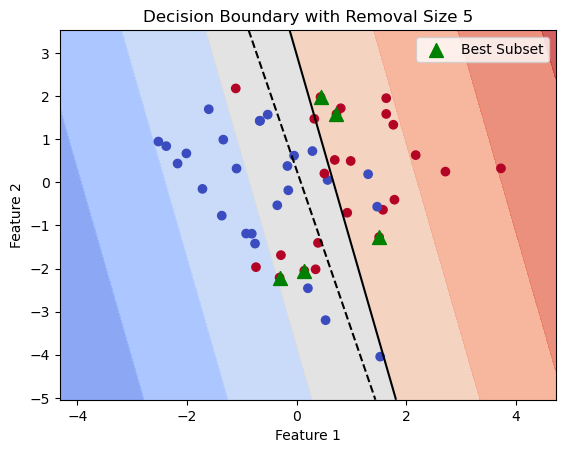

In [8]:
for subset_size in range(1, max_size + 1):
	print(f"Best Subset of Removed Data Points for Total Loss with Size {subset_size}: {total_loss[0][subset_size-1]}")

	# Plot the decision boundary of the original model and the reduced model, and mark the test point
	plt.figure()

	# Plot the decision boundary of the reduced model (solid line)
	plt.contourf(xx, yy, total_loss[1][subset_size-1], cmap=plt.cm.coolwarm, alpha=0.8)
	plt.contour(xx, yy, total_loss[1][subset_size-1], colors='black', linestyles='-', levels=[0])

	# Plot the decision boundary of the original model (dashed line)
	original_Z = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
	plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

	# Mark the dataset points with a marker ('o' symbol)
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')

	# Mark the best subset of removed data points with a different marker ('^' symbol)
	best_subset_points = np.take(X_train, total_loss[0][subset_size-1], axis=0).reshape(-1, 2)
	plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='g', marker='^', s=100, label="Best Subset")

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title(f'Decision Boundary with Removal Size {subset_size}')
	plt.legend()
	plt.show()

Best Subset of Removed Data Points for Parameter Changes with Size 1: (41,)


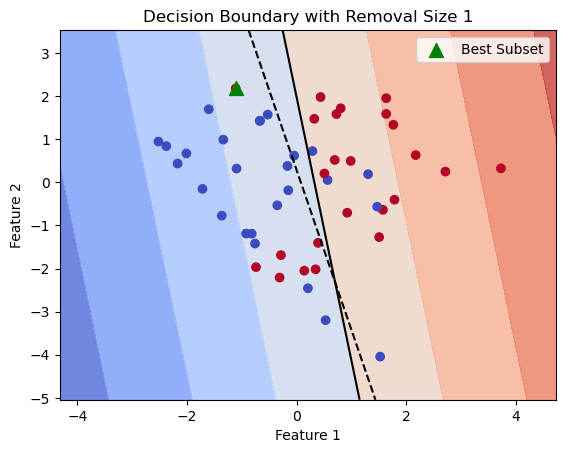

Best Subset of Removed Data Points for Parameter Changes with Size 2: (6, 41)


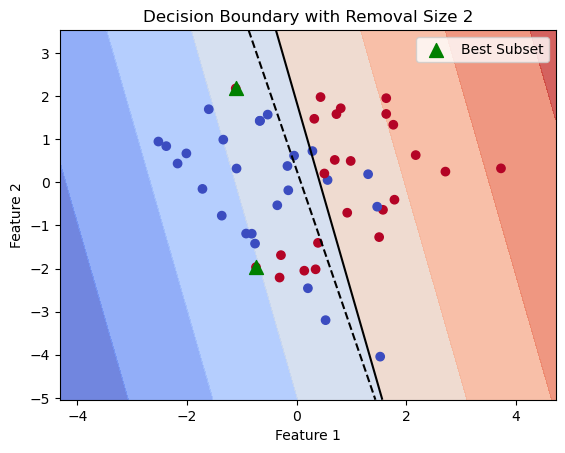

Best Subset of Removed Data Points for Parameter Changes with Size 3: (3, 6, 40)


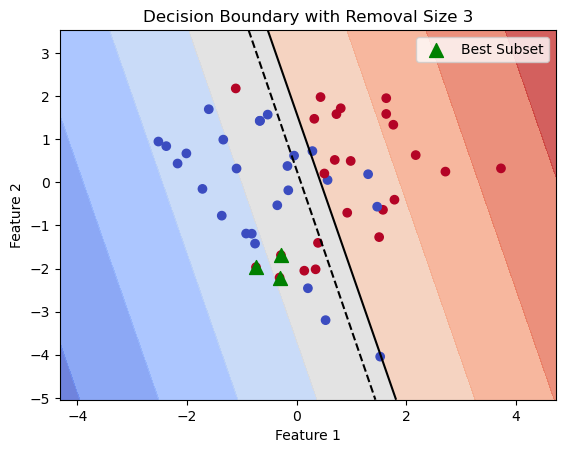

Best Subset of Removed Data Points for Parameter Changes with Size 4: (1, 3, 6, 40)


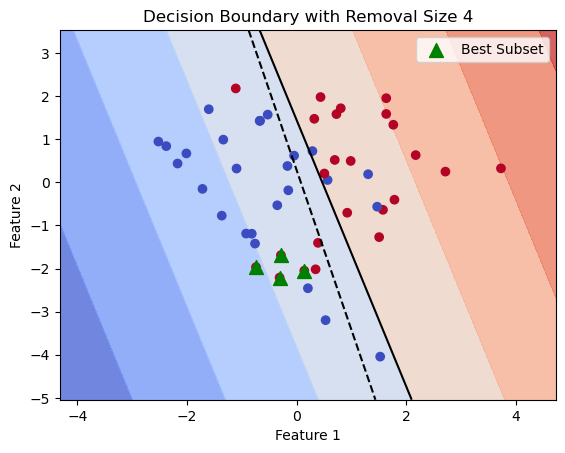

Best Subset of Removed Data Points for Parameter Changes with Size 5: (1, 3, 6, 7, 40)


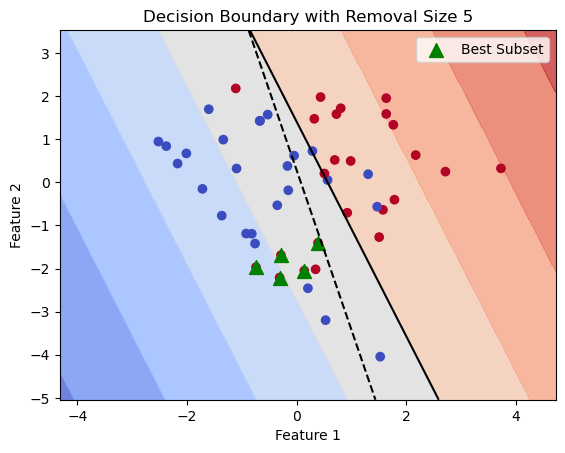

In [9]:
for subset_size in range(1, max_size + 1):
	print(f"Best Subset of Removed Data Points for Parameter Changes with Size {subset_size}: {parameter[0][subset_size-1]}")

	# Plot the decision boundary of the original model and the reduced model, and mark the test point
	plt.figure()

	# Plot the decision boundary of the reduced model (solid line)
	plt.contourf(xx, yy, parameter[1][subset_size-1], cmap=plt.cm.coolwarm, alpha=0.8)
	plt.contour(xx, yy, parameter[1][subset_size-1], colors='black', linestyles='-', levels=[0])

	# Plot the decision boundary of the original model (dashed line)
	original_Z = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
	plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

	# Mark the dataset points with a marker ('o' symbol)
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')

	# Mark the best subset of removed data points with a different marker ('^' symbol)
	best_subset_points = np.take(X_train, parameter[0][subset_size-1], axis=0).reshape(-1, 2)
	plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='g', marker='^', s=100, label="Best Subset")

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title(f'Decision Boundary with Removal Size {subset_size}')
	plt.legend()
	plt.show()